In [1]:
import os

# must be done before first numpy import
os.environ['NUMPY_EXPERIMENTAL_ARRAY_FUNCTION'] = '0'

import xarray as xr
import numpy as np
import gcsfs
import zarr
import xrft
from pyresample import image, geometry
import json
from matplotlib import pyplot as plt
import dask
%matplotlib inline

In [2]:
from dask_kubernetes import KubeCluster
cluster = KubeCluster(n_workers=10, env={"NUMPY_EXPERIMENTAL_ARRAY_FUNCTION": "0"})
cluster

In [3]:
from dask.distributed import Client

client = Client(cluster)
client

Client Scheduler: tcp://10.32.60.184:41717 Dashboard: /user/0000-0001-5999-4917/proxy/8787/status,Cluster Workers: 4 Cores: 8 Memory: 46.00 GB


In [26]:
client.restart()

Client Scheduler: tcp://10.32.60.184:41717 Dashboard: /user/0000-0001-5999-4917/proxy/8787/status,Cluster Workers: 10 Cores: 20 Memory: 115.00 GB


In [4]:
def check_env_vars():
    import os
    return os.environ['NUMPY_EXPERIMENTAL_ARRAY_FUNCTION']

client.run(check_env_vars)

{'tcp://10.32.168.4:33347': '0',
 'tcp://10.32.168.5:36419': '0',
 'tcp://10.32.61.4:34501': '0',
 'tcp://10.32.61.5:37703': '0'}

In [5]:
from xmitgcm.llcreader.llcmodel import faces_dataset_to_latlon

def setup_global_dataset(nt):

    gcs = gcsfs.GCSFileSystem(token='anon')
    ds_sst_full = xr.open_zarr(gcs.get_mapper('pangeo-data/llc4320_surface/SST'),
                               consolidated=True, chunks=False)
    ds_ssh_full = xr.open_zarr(gcs.get_mapper('pangeo-data/llc4320_surface/Eta'),
                               consolidated=True, chunks=False)
    ds_grid = xr.open_zarr(gcs.get_mapper('pangeo-data/llc4320_surface/grid'),
                           consolidated=True)
    coord_vars_to_keep = ['XC', 'YC']
    rename_coords = {'XC': 'lon', 'YC': 'lat'}
    ds_grid = (ds_grid.reset_coords()[coord_vars_to_keep]
                      .reset_coords(drop=True)
                      .set_coords(coord_vars_to_keep)
                      .rename(rename_coords))
    
    ds_full = xr.merge([ds_sst_full, ds_ssh_full, ds_grid])
    
    ds_faces = ds_full.isel(time=nt).chunk({'face': 1})
    
    ds_ll = faces_dataset_to_latlon(ds_faces, metric_vector_pairs=[])
    return ds_ll.drop('face')

In [6]:
%time ds = setup_global_dataset(0)
ds

CPU times: user 279 ms, sys: 35.5 ms, total: 314 ms
Wall time: 1.75 s


<xarray.Dataset>
Dimensions:  (i: 17280, j: 12960)
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 ... 17274 17275 17276 17277 17278 17279
  * j        (j) int64 0 1 2 3 4 5 6 ... 12954 12955 12956 12957 12958 12959
    time     datetime64[ns] 2011-09-13
    lon      (j, i) float32 dask.array<shape=(12960, 17280), chunksize=(4320, 4320)>
    lat      (j, i) float32 dask.array<shape=(12960, 17280), chunksize=(4320, 4320)>
Data variables:
    SST      (j, i) float32 dask.array<shape=(12960, 17280), chunksize=(4320, 4320)>
    Eta      (j, i) float32 dask.array<shape=(12960, 17280), chunksize=(4320, 4320)>

In [7]:
def load_regions():
    with open('land_free_regions_llc4320.json') as f:
        d = json.load(f)
    return xr.Dataset.from_dict(d)

regions = load_regions()
regions

<xarray.Dataset>
Dimensions:  (point: 321)
Dimensions without coordinates: point
Data variables:
    lon      (point) float64 -32.52 -55.76 -166.8 ... -32.72 -12.24 0.4759
    lat      (point) float64 -74.01 -73.79 -73.56 -73.28 ... 62.82 68.88 69.47
    j        (point) int64 2160 2160 2160 2160 2160 ... 11340 11880 12420 12420
    i        (point) int64 0 10260 10800 11340 11880 ... 10260 16200 0 1080 1620
Attributes:
    region_size:  540

In [8]:
def load_patch(ds=None, regions=None, nregion=None):
    region = regions.sel(point=nregion)
    size_j, size_i = regions.region_size, regions.region_size
    i_start = region.i.values.item()
    j_start = region.j.values.item()
    ds_patch = ds.isel(i=slice(i_start, i_start + size_i),
                              j=slice(j_start, j_start + size_j))
    return ds_patch

In [10]:
def target_area_def(ds_patch):
    """Get a pyresample area_def for a given patch."""
    size_i = len(ds_patch.i)
    size_j = len(ds_patch.j)
    center_point = ds_patch.isel(i=size_i//2, j=size_j//2)
    center_lon, center_lat = center_point.lon.values.item(), center_point.lat.values.item()
    area_id = 'local_grid'
    description = 'Local Lambert Equal Area Grid'
    proj_id = 'local_grid'
    proj_dict = {'proj': 'laea', 'lat_0': center_lat, 'lon_0': center_lon, 'units': 'm'} #  'a': 6371228.0,

    # 1 km resolution
    width = 512
    height = 512

    # 512 x 512 km
    area_extent = (-256000., -256000., 256000., 256000.)
    area_def = geometry.AreaDefinition(area_id, description, proj_id, proj_dict,
                                       width, height, area_extent)
    return area_def


def image_to_dataset(im, varname='foo'):
    """Wrap pyresample image in xarray dataset."""
    geo_def = im.geo_def
    units = geo_def.proj_dict['units']
    lons, lats =  geo_def.get_lonlats()
    ds_resampled = xr.DataArray(im.image_data, dims=['y', 'x'],
                                coords={'x': ('x', geo_def.projection_x_coords, {'units':  units}),
                                        'y': ('x', geo_def.projection_y_coords, {'units':  units}),
                                        'lon': (['y', 'x'], lons),
                                        'lat': (['y', 'x'], lats)
                                       }, name=varname).to_dataset()
    ds_resampled.coords['projection'] = ('projection', [1], geo_def.proj_dict)
    
    # what metadata to save? this seems relevant
    # http://cfconventions.org/Data/cf-conventions/cf-conventions-1.7/cf-conventions.html#grid-mappings-and-projections
    return ds_resampled

def resample_patch(ds_patch, varname='SST'):
    """Resample a patch of ocean."""
    grid_def = geometry.GridDefinition(lons=ds_patch.lon.values, lats=ds_patch.lat.values)
    data = ds_patch[varname].to_masked_array()
    im = image.ImageContainerBilinear(data, grid_def,
                                      radius_of_influence=10000., fill_value=None)
    
    area_def = target_area_def(ds_patch)
    im_resampled = im.resample(area_def)
    resampled_ds = image_to_dataset(im_resampled, varname=varname)
    return resampled_ds.drop(['lon', 'lat', 'projection'])
    #return im_resampled.image_data.filled(np.nan).astype('f4')

In [11]:
import json
import prefect

with open('pangeo-181919-0c1f01383379.json') as fp:
    token = json.load(fp)
prefect.context.setdefault('secrets', {})['GOOGLE_APPLICATION_CREDENTIALS'] = token

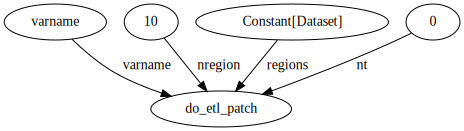

In [37]:
from prefect import Flow, task, unmapped, Parameter
from prefect.client import Secret
import gcsfs
import zarr
import datetime

@task(max_retries=3, retry_delay=datetime.timedelta(seconds=1))
def do_etl_patch(regions, nt: int, nregion: int, varname: str):
    # not necessary after fixing env variable issue
    with dask.config.set(scheduler='single-threaded'):
        ds_full = setup_global_dataset(nt)
        patch = load_patch(ds=ds, regions=regions, nregion=nregion)
        patch.load()
    patch_resampled = resample_patch(patch)
    return patch_resampled

@task(max_retries=3, retry_delay=datetime.timedelta(seconds=1))
def combine_and_store_arrays(patches, nt: int, varname: str):
    ds_concat = xr.concat(patches, dim='region')
    
    # get credentials and set up store
    token = Secret("GOOGLE_APPLICATION_CREDENTIALS").get()
    fs = gcsfs.GCSFileSystem(token=token)
    store_name = f'pangeo-ocean-ml/LLC4320/{varname}.{nt:010d}.zarr'
    gcsmap = fs.get_mapper(store_name)
    
    nx, ny = ds_concat.dims['x'], ds_concat.dims['y']
    encoding = {varname: {'chunks': (1, ny, nx)}}
    # consolidating here actually doesn't work; consolidated metadata is empty
    ds_concat.to_zarr(gcsmap, encoding=encoding, mode='w')
    
    # does this clear the cache? yes
    fs = gcsfs.GCSFileSystem(token=token)
    gcsmap = fs.get_mapper(store_name)
    zarr.consolidate_metadata(gcsmap)
    
with Flow('ETL_Simple') as flow_simple:
    regions = load_regions()
    varname = Parameter('varname')
    do_etl_patch(regions, 0, 10, varname)
    
    
with Flow('ETL_patches_mapped') as flow_mapped:
    regions = load_regions()
    nt = Parameter('nt', default=0)
    varname = Parameter('varname', default='SST')    
    nregion = list(range(regions.dims['point']))
    # why do we need `unmapped(nt)` but not `unmapped(varname)`?
    patches = do_etl_patch.map(unmapped(regions), unmapped(nt), nregion, unmapped(varname))
    # todo: refactor so that all the tasks don't bottleneck but rather 
    #       write in a streaming fashion
    result = combine_and_store_arrays(patches, nt, varname)

flow_simple.visualize() 

In [13]:
from prefect.engine.executors import DaskExecutor
executor = DaskExecutor(address=cluster.scheduler_address)

In [ ]:
for nt in range(0, 9030, 24*3+1):
    flow_mapped.run(nt=nt, executor=executor)

[2019-09-10 03:36:58,836] INFO - prefect.FlowRunner | Beginning Flow run for 'ETL_patches_mapped'
[2019-09-10 03:36:58,839] INFO - prefect.FlowRunner | Starting flow run.
